In [ ]:
#Imports & global options
import os, glob, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

#Analysis knobs (tweak if you like)
ANALYZE_BTC_ONLY = True         #BTC only
BTC_MATCH_REGEX  = r"BTC"       # used if ANALYZE_BTC_ONLY=True
DROP_NEUTRAL     = True
CLOSE_PNL_NONZERO_ONLY = False

# Output folders
CSV_DIR = "csv_files"
FIG_DIR = "outputs"
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("Setup OK.")


Setup OK.


In [ ]:

IN_COLAB = False
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    pass

fear_path = None
hist_path = None

if IN_COLAB:

    fg_candidates   = glob.glob("/content/fear_greed_index*.csv")
    hist_candidates = glob.glob("/content/historical_data*.csv")

    if fg_candidates and hist_candidates:
        fear_path = max(fg_candidates,   key=os.path.getmtime)
        hist_path = max(hist_candidates, key=os.path.getmtime)
        print("Found existing uploads:")
        print("  Fear/Greed CSV:", fear_path)
        print("  Trades CSV   :", hist_path)
    else:
        print("Upload fear_greed_index.csv and historical_data.csv")
        up1 = files.upload()   # pick fear_greed_index.csv
        up2 = files.upload()   # pick historical_data.csv
        # Resolve paths from upload dicts
        fear_path = next(iter(up1.keys()))
        hist_path = next(iter(up2.keys()))
else:
    fear_path = r"./fear_greed_index.csv"
    hist_path = r"./historical_data.csv"

# Final sanity check
for p in [fear_path, hist_path]:
    assert p and os.path.exists(p), f"Missing file: {p}"

print("Fear/Greed CSV:", fear_path)
print("Trades CSV   :", hist_path)


Found existing uploads:
  Fear/Greed CSV: /content/fear_greed_index (1).csv
  Trades CSV   : /content/historical_data (1).csv
Fear/Greed CSV: /content/fear_greed_index (1).csv
Trades CSV   : /content/historical_data (1).csv


In [ ]:
# Read sentiment (robust to header name variations)
sent_raw = pd.read_csv(fear_path)
scols = {c.lower().strip(): c for c in sent_raw.columns}

date_col  = scols.get("date") or scols.get("timestamp")
class_col = scols.get("classification") or scols.get("class")
if not date_col or not class_col:
    raise ValueError(f"Sentiment needs columns [Date, Classification]; found: {list(sent_raw.columns)}")

sent = sent_raw.rename(columns={date_col: "Date", class_col: "Classification"}).copy()

# Parse Date -> UTC day
sent["Date"] = pd.to_datetime(sent["Date"], errors="coerce", utc=True).dt.floor("D")
sent["Classification"] = sent["Classification"].astype(str).str.strip().str.title()

# Map 5 classes to Fear/Greed binary
fear_group  = {"Extreme Fear", "Fear"}
greed_group = {"Extreme Greed", "Greed"}
def map_fg(x):
    if x in fear_group:  return "Fear"
    if x in greed_group: return "Greed"
    return "Neutral"

sent["FG2"] = sent["Classification"].map(map_fg)
sent = (sent.dropna(subset=["Date"])
            .drop_duplicates("Date")
            .sort_values("Date")[["Date","Classification","FG2"]])

print("Sentiment head:")
display(sent.head())
print("FG2 counts:\n", sent["FG2"].value_counts(dropna=False))


Sentiment head:


,Date,Classification,FG2
0,2018-02-01 00:00:00+00:00,Fear,Fear
1,2018-02-02 00:00:00+00:00,Extreme Fear,Fear
2,2018-02-03 00:00:00+00:00,Fear,Fear
3,2018-02-04 00:00:00+00:00,Extreme Fear,Fear
4,2018-02-05 00:00:00+00:00,Extreme Fear,Fear


FG2 counts:
 FG2
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


In [ ]:
tr_raw = pd.read_csv(hist_path, low_memory=False)
tr = tr_raw.rename(columns={c: c.strip() for c in tr_raw.columns}).copy()

#Time handling: prefer 'Timestamp' (epoch ms); else 'Timestamp IST' (IST→UTC); else 'time' if already UTC
if "Timestamp" in tr.columns:
    tr["time"] = pd.to_datetime(tr["Timestamp"], unit="ms", errors="coerce", utc=True)
elif "Timestamp IST" in tr.columns:
    t = pd.to_datetime(tr["Timestamp IST"], errors="coerce")
    tr["time"] = (t.dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT")
                    .dt.tz_convert("UTC"))
elif "time" in tr.columns:
    tr["time"] = pd.to_datetime(tr["time"], errors="coerce", utc=True)
else:
    raise KeyError("No usable timestamp column found (need 'Timestamp', 'Timestamp IST', or 'time').")

tr = tr.dropna(subset=["time"]).copy()

#Symbol normalization
if "Coin" in tr.columns:
    tr["symbol"] = tr["Coin"].astype(str).str.upper()
elif "symbol" in tr.columns:
    tr["symbol"] = tr["symbol"].astype(str).str.upper()
else:
    raise KeyError("No symbol/coin column found (expected 'Coin' or 'symbol').")

# Optional BTC-only filter
if ANALYZE_BTC_ONLY:
    mask_btc = tr["symbol"].str.contains(BTC_MATCH_REGEX, na=False, regex=True)
    tr = tr.loc[mask_btc].copy()
    print("Rows after BTC filter:", len(tr))

#Notional: prefer 'Size USD'; else 'Size Tokens' * 'Execution Price'
px        = pd.to_numeric(tr.get("Execution Price", np.nan), errors="coerce")
size_usd  = pd.to_numeric(tr.get("Size USD", np.nan),         errors="coerce")
size_tkn  = pd.to_numeric(tr.get("Size Tokens", np.nan),      errors="coerce")

notional = size_usd.copy()
if notional.isna().all():
    notional = size_tkn * px
tr["notional"] = notional.abs()

#Direction (string-safe): from 'Side' or fallback to 'Direction'
side    = tr.get("Side", "").astype(str).str.lower()
dir_col = tr.get("Direction", "").astype(str).str.lower()

direction = pd.Series(pd.NA, index=tr.index, dtype="string")
direction = direction.mask(side.isin(["buy","long"]),  "long")
direction = direction.mask(side.isin(["sell","short"]), "short")
direction = direction.mask(dir_col.isin(["buy","long"]),  "long")
direction = direction.mask(dir_col.isin(["sell","short"]), "short")
tr["direction"] = direction

#Closed PnL + close-event proxy (no explicit 'event' column in your file)
closedpnl = pd.to_numeric(tr.get("Closed PnL", np.nan), errors="coerce")
tr["pnl_norm"] = closedpnl / tr["notional"]

if CLOSE_PNL_NONZERO_ONLY:
    tr["is_close_event"] = closedpnl.notna() & (closedpnl != 0)
else:
    tr["is_close_event"] = closedpnl.notna()

#Day key for joining to sentiment (UTC floored)
tr["sentiment_day"] = tr["time"].dt.floor("D")

print("Trades head (normalized):")
display(tr[["time","symbol","notional","direction","pnl_norm","is_close_event"]].head())
print("Date range (trades):", tr["sentiment_day"].min(), "→", tr["sentiment_day"].max())


Rows after BTC filter: 26064
Trades head (normalized):


,time,symbol,notional,direction,pnl_norm,is_close_event
3001,2025-02-19 21:20:00+00:00,BTC,7061.59,long,0.0,True
3002,2025-02-19 21:20:00+00:00,BTC,9999.74,long,0.0,True
3003,2025-02-19 21:20:00+00:00,BTC,770.73,long,0.0,True
3004,2025-02-19 21:20:00+00:00,BTC,10176.59,long,0.0,True
3005,2025-02-19 21:20:00+00:00,BTC,217804.66,long,0.0,True


Date range (trades): 2023-11-14 00:00:00+00:00 → 2025-06-15 00:00:00+00:00


In [ ]:
def iqr(s):
    s = s.dropna()
    return s.quantile(0.75) - s.quantile(0.25) if len(s) else np.nan

# Base set with valid notional
g = tr[tr["notional"].fillna(0) > 0].copy()

# Daily core metrics
daily = (g.groupby("sentiment_day")
           .agg(n_trades=("symbol","size"),
                volume_notional=("notional","sum"))
           .reset_index())

# Net-long share per day
ls = (g.groupby(["sentiment_day","direction"])["notional"].sum()
        .unstack(fill_value=0))
daily = daily.merge(
    (ls.get("long", 0) / (ls.get("long",0) + ls.get("short",0))).rename("net_long_share").reset_index(),
    on="sentiment_day", how="left"
)

# PnL stats on close events only
close = g[g["is_close_event"] & g["pnl_norm"].notna()]
pnl = (close.groupby("sentiment_day")["pnl_norm"]
             .agg(pnl_med="median",
                  pnl_iqr=iqr,
                  pnl_p5=lambda s: s.quantile(0.05),
                  pnl_p95=lambda s: s.quantile(0.95))
             .reset_index())

# Attach labels (binary FG2, and we keep original 5-class too for reference)
daily = (daily
         .merge(pnl, on="sentiment_day", how="left")
         .merge(sent[["Date","FG2","Classification"]], left_on="sentiment_day", right_on="Date", how="left"))

print("Daily head:")
display(daily.head())
print("Labeled days:", daily["FG2"].notna().sum(), "/", len(daily))


Daily head:


,sentiment_day,n_trades,volume_notional,net_long_share,pnl_med,pnl_iqr,pnl_p5,pnl_p95,Date,FG2,Classification
0,2023-11-14 00:00:00+00:00,227,4.654492e+06,0.504899,0.0,0.000723,-0.003313,0.005372,2023-11-14 00:00:00+00:00,Greed,Greed
1,2024-03-09 00:00:00+00:00,1451,1.157254e+07,0.500329,0.0,0.000075,-0.001360,0.001373,2024-03-09 00:00:00+00:00,Greed,Extreme Greed
2,2024-07-03 00:00:00+00:00,217,1.375887e+06,0.496190,0.0,0.001504,-0.003830,0.056337,2024-07-03 00:00:00+00:00,Neutral,Neutral
3,2024-10-27 00:00:00+00:00,2072,3.370609e+07,0.508637,0.0,0.003070,-0.001268,0.020315,2024-10-27 00:00:00+00:00,Greed,Greed
4,2025-02-19 00:00:00+00:00,16168,3.503168e+08,0.509401,0.0,0.001916,0.000000,0.011846,2025-02-19 00:00:00+00:00,Fear,Fear


Labeled days: 5 / 6


In [ ]:
# Optionally drop Neutral for the headline binary summary
daily_bin = daily.copy()
if DROP_NEUTRAL:
    daily_bin = daily_bin[daily_bin["FG2"].isin(["Fear","Greed"])]

summary = (daily_bin.groupby("FG2")
              .agg(med_pnl_norm=("pnl_med","median"),
                   med_net_long=("net_long_share","median"),
                   med_volume_usd=("volume_notional","median"))
              .round(6))
print("Class summary (Fear vs Greed):")
display(summary)

# Quick coverage checks
print("Close events used:", len(close))
print("Any NaN in net_long_share?:", daily["net_long_share"].isna().sum())


Class summary (Fear vs Greed):


,med_pnl_norm,med_net_long,med_volume_usd
FG2,,,
Fear,0.0,0.509401,3.503168e+08
Greed,0.0,0.504899,1.157254e+07


Close events used: 26064
Any NaN in net_long_share?: 0


In [ ]:
daily.to_csv(os.path.join(CSV_DIR, "daily_metrics_base.csv"), index=False)
close.to_csv(os.path.join(CSV_DIR, "close_events_used.csv"), index=False)

print("Saved:")
print(" ", os.path.join(CSV_DIR, "daily_metrics_base.csv"))
print(" ", os.path.join(CSV_DIR, "close_events_used.csv"))


Saved:
  csv_files/daily_metrics_base.csv
  csv_files/close_events_used.csv


/tmp/ipython-input-1905862345.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Fear","Greed"], showfliers=False)


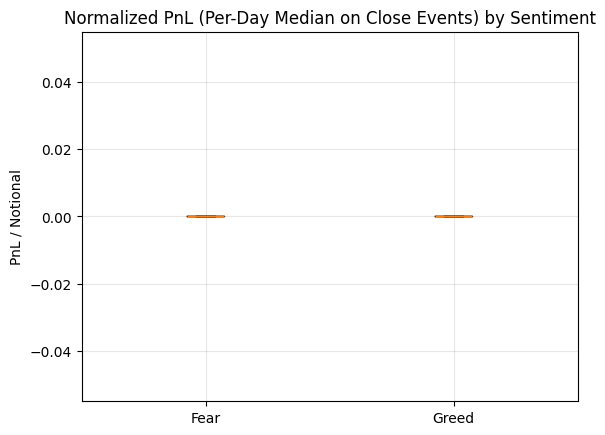

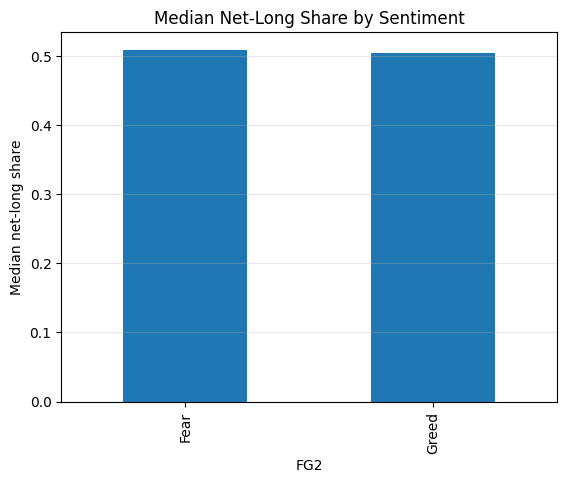

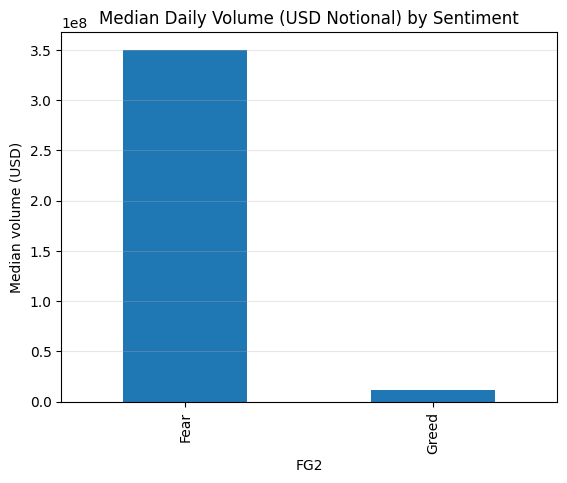

Saved figures in: outputs


In [ ]:
# 1) PnL/Notional (close events) by class
plt.figure()
to_plot = daily_bin.dropna(subset=["pnl_med","FG2"])
# Simple boxplot using per-day medians
data = [to_plot.loc[to_plot["FG2"]=="Fear","pnl_med"].dropna().values,
        to_plot.loc[to_plot["FG2"]=="Greed","pnl_med"].dropna().values]
plt.boxplot(data, labels=["Fear","Greed"], showfliers=False)
plt.title("Normalized PnL (Per-Day Median on Close Events) by Sentiment")
plt.ylabel("PnL / Notional")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIG_DIR, "fig_pnl_norm_by_class.png"))
plt.show()

# 2) Net-long share by class (per-day medians)
plt.figure()
vals = (daily_bin.groupby("FG2")["net_long_share"].median())
vals.plot(kind="bar")
plt.title("Median Net-Long Share by Sentiment")
plt.ylabel("Median net-long share")
plt.grid(True, axis="y", alpha=0.3)
plt.savefig(os.path.join(FIG_DIR, "fig_net_long_share_by_class.png"))
plt.show()

# 3) Volume by class (per-day median USD)
plt.figure()
vals2 = (daily_bin.groupby("FG2")["volume_notional"].median())
vals2.plot(kind="bar")
plt.title("Median Daily Volume (USD Notional) by Sentiment")
plt.ylabel("Median volume (USD)")
plt.grid(True, axis="y", alpha=0.3)
plt.savefig(os.path.join(FIG_DIR, "fig_volume_by_class.png"))
plt.show()

print("Saved figures in:", FIG_DIR)


In [ ]:
print("Trade window :", tr["sentiment_day"].min().date(), "→", tr["sentiment_day"].max().date())
print("Sentiment win:", sent["Date"].min().date(), "→", sent["Date"].max().date())

print("\nTop symbols (after BTC filter may be just BTC):")
display(tr["symbol"].value_counts().head(10))

print("\nTail risk check (Greed vs Fear):")
tail = (daily_bin.dropna(subset=["pnl_p5","pnl_p95"])
        .groupby("FG2")[["pnl_p5","pnl_p95"]].median().round(6))
display(tail)


Trade window : 2023-11-14 → 2025-06-15
Sentiment win: 2018-02-01 → 2025-05-02

Top symbols (after BTC filter may be just BTC):


,count
symbol,
BTC,26064



Tail risk check (Greed vs Fear):


,pnl_p5,pnl_p95
FG2,,
Fear,0.00000,0.011846
Greed,-0.00136,0.005372


In [ ]:
def fmt(x):
    return "—" if pd.isna(x) else f"{x:.6g}"

rowF = summary.loc["Fear"]  if "Fear"  in summary.index else pd.Series(dtype=float)
rowG = summary.loc["Greed"] if "Greed" in summary.index else pd.Series(dtype=float)

lines = [
    f"Days covered (with FG2 label): {int(daily_bin['FG2'].notna().sum())} of {len(daily)}",
    f"Close events used (rows)     : {len(close)}",
    "",
    "Headline deltas (Greed – Fear):",
    f"  Δ median PnL/Notional       : {fmt(rowG.get('med_pnl_norm', np.nan) - rowF.get('med_pnl_norm', np.nan))}",
    f"  Δ median Net-Long Share     : {fmt(rowG.get('med_net_long', np.nan) - rowF.get('med_net_long', np.nan))}",
    f"  Δ median Volume (USD)       : {fmt(rowG.get('med_volume_usd', np.nan) - rowF.get('med_volume_usd', np.nan))}",
]
print("\n".join(lines))


Days covered (with FG2 label): 4 of 6
Close events used (rows)     : 26064

Headline deltas (Greed – Fear):
  Δ median PnL/Notional       : 0
  Δ median Net-Long Share     : -0.004502
  Δ median Volume (USD)       : -3.38744e+08


In [ ]:
# Inspect which days are labeled and their classes
view = (daily[["sentiment_day","FG2","Classification","n_trades","volume_notional","net_long_share","pnl_med"]]
        .sort_values("sentiment_day"))
print("Daily coverage (after BTC filter):")
display(view)

print("\nCounts by class (days):")
display(view["FG2"].value_counts(dropna=False))

# Trades/volume per class (using per-day sums)
per_day = tr.assign(day=tr["sentiment_day"])
by_class = (per_day.merge(sent[["Date","FG2"]], left_on="day", right_on="Date", how="left")
            .groupby("FG2")
            .agg(trades=("symbol","size"),
                 volume_usd=("notional","sum"))
            .sort_values("trades", ascending=False))
print("\nLoad by class (trades & notional):")
display(by_class)


Daily coverage (after BTC filter):


,sentiment_day,FG2,Classification,n_trades,volume_notional,net_long_share,pnl_med
0,2023-11-14 00:00:00+00:00,Greed,Greed,227,4.654492e+06,0.504899,0.0
1,2024-03-09 00:00:00+00:00,Greed,Extreme Greed,1451,1.157254e+07,0.500329,0.0
2,2024-07-03 00:00:00+00:00,Neutral,Neutral,217,1.375887e+06,0.496190,0.0
3,2024-10-27 00:00:00+00:00,Greed,Greed,2072,3.370609e+07,0.508637,0.0
4,2025-02-19 00:00:00+00:00,Fear,Fear,16168,3.503168e+08,0.509401,0.0
5,2025-06-15 00:00:00+00:00,NaN,NaN,5929,2.426063e+08,0.482709,0.0



Counts by class (days):


,count
FG2,
Greed,3
Neutral,1
Fear,1
NaN,1



Load by class (trades & notional):


,trades,volume_usd
FG2,,
Fear,16168,3.503168e+08
Greed,3750,4.993312e+07
Neutral,217,1.375887e+06


In [ ]:
# Keep Neutral in view for diagnostic power
daily_3class = daily.copy()
daily_3class["FG2_or_Neutral"] = daily_3class["FG2"].fillna("Neutral")

summary_3 = (daily_3class.groupby("FG2_or_Neutral")
             .agg(med_pnl_norm=("pnl_med","median"),
                  med_net_long=("net_long_share","median"),
                  med_volume_usd=("volume_notional","median"))
             .round(6))
print("Three-class summary (Fear / Neutral / Greed):")
display(summary_3)


Three-class summary (Fear / Neutral / Greed):


,med_pnl_norm,med_net_long,med_volume_usd
FG2_or_Neutral,,,
Fear,0.0,0.509401,3.503168e+08
Greed,0.0,0.504899,1.157254e+07
Neutral,0.0,0.489449,1.219911e+08


In [ ]:
%pip -q install scipy
from scipy import stats
import numpy as np

# Extract per-day medians for each class (binary view)
fear_vals  = daily.loc[daily["FG2"]=="Fear",  "pnl_med"].dropna().values
greed_vals = daily.loc[daily["FG2"]=="Greed", "pnl_med"].dropna().values

print(f"Per-day PnL/Notional medians — Fear n={len(fear_vals)}, Greed n={len(greed_vals)}")
print("Fear values:", fear_vals)
print("Greed values:", greed_vals)

# Mann–Whitney U (non-parametric)
if len(fear_vals) > 0 and len(greed_vals) > 0:
    u = stats.mannwhitneyu(greed_vals, fear_vals, alternative="two-sided")
    print("Mann–Whitney U test:", u)

# Cliff's delta (effect size; -1..+1)
def cliffs_delta(x, y):
    # delta = P(X>Y) - P(X<Y)
    gt = 0; lt = 0
    for a in x:
        gt += np.sum(a > y)
        lt += np.sum(a < y)
    n = len(x)*len(y)
    return (gt - lt)/n if n else np.nan

if len(fear_vals) and len(greed_vals):
    delta = cliffs_delta(greed_vals, fear_vals)
    print("Cliff's δ (Greed vs Fear):", round(delta, 4))

# Bootstrap 95% CI for difference in medians (Greed - Fear)
def bootstrap_median_diff(x, y, n=20000, seed=0):
    if len(x)==0 or len(y)==0: return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.median(yb) - np.median(xb))
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return lo, hi

ci_lo, ci_hi = bootstrap_median_diff(fear_vals, greed_vals)
print("Bootstrap 95% CI for Δ median PnL/Notional (Greed - Fear):", (ci_lo, ci_hi))


Per-day PnL/Notional medians — Fear n=1, Greed n=3
Fear values: [0.]
Greed values: [0. 0. 0.]
Mann–Whitney U test: MannwhitneyuResult(statistic=np.float64(1.5), pvalue=np.float64(1.0))
Cliff's δ (Greed vs Fear): 0.0
Bootstrap 95% CI for Δ median PnL/Notional (Greed - Fear): (np.float64(0.0), np.float64(0.0))


In [ ]:
# Build a simple realized-vol proxy from intraday execution prices
px = pd.to_numeric(tr.get("Execution Price"), errors="coerce")
px_df = tr.loc[px.notna(), ["sentiment_day","time"]].copy()
px_df["px"] = px.dropna().values
px_df = px_df.sort_values(["sentiment_day","time"])

def day_vol(g):
    v = g["px"].values
    if v.size < 3:
        return np.nan
    rets = np.diff(np.log(v))
    return float(np.std(rets))

vol = px_df.groupby("sentiment_day").apply(day_vol).rename("realized_vol").reset_index()

# Bucket by terciles (ignore NaNs)
qs = vol["realized_vol"].quantile([0.33, 0.66])
def bucket(x):
    if pd.isna(x): return np.nan
    if x <= qs.iloc[0]: return "Low"
    if x <= qs.iloc[1]: return "Mid"
    return "High"

vol["vol_bucket"] = vol["realized_vol"].apply(bucket)

# Merge and compute class gaps within each vol bucket
daily_vol = (daily.merge(vol, on="sentiment_day", how="left")
                 .dropna(subset=["FG2"]))  # keep only labeled for comparison

print("Per-bucket class medians (pnl_med, net_long_share):")
for b in ["Low","Mid","High"]:
    sub = daily_vol[(daily_vol["vol_bucket"]==b) & (daily_vol["FG2"].isin(["Fear","Greed"]))]
    if sub.empty:
        print(b, "→ no data");
        continue
    tab = (sub.groupby("FG2")[["pnl_med","net_long_share","volume_notional"]]
              .median().round(6))
    print(f"\nBucket={b}")
    display(tab)


Per-bucket class medians (pnl_med, net_long_share):

Bucket=Low


/tmp/ipython-input-1025539246.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vol = px_df.groupby("sentiment_day").apply(day_vol).rename("realized_vol").reset_index()


,pnl_med,net_long_share,volume_notional
FG2,,,
Greed,0.0,0.504899,4654492.23



Bucket=Mid


,pnl_med,net_long_share,volume_notional
FG2,,,
Fear,0.0,0.509401,3.503168e+08
Greed,0.0,0.500329,1.157254e+07



Bucket=High


,pnl_med,net_long_share,volume_notional
FG2,,,
Greed,0.0,0.508637,33706085.49


In [ ]:
# Shift the day key before joining to labels, then recompute the class summary
def summary_with_shift(day_shift):
    tmp = tr.copy()
    tmp["sentiment_day_shift"] = (tmp["time"] + pd.Timedelta(days=day_shift)).dt.floor("D")
    # rebuild daily medians
    g = tmp[tmp["notional"].fillna(0)>0]
    daily_s = (g.groupby("sentiment_day_shift")
               .agg(pnl_med=("pnl_norm","median"),
                    volume_notional=("notional","sum"),
                    net_long_share=("direction", lambda s: np.nan))  # placeholder; recompute below
               .reset_index())
    # net-long share
    ls = (g.groupby(["sentiment_day_shift","direction"])["notional"].sum()
          .unstack(fill_value=0))
    if not ls.empty:
        nls = (ls.get("long",0) / (ls.get("long",0)+ls.get("short",0))).rename("net_long_share").reset_index()
        daily_s.drop(columns=["net_long_share"], inplace=True, errors="ignore")
        daily_s = daily_s.merge(nls, on="sentiment_day_shift", how="left")

    # attach labels with matching shift
    lab = sent[["Date","FG2"]].rename(columns={"Date":"sentiment_day_shift"})
    daily_s = daily_s.merge(lab, on="sentiment_day_shift", how="left")
    # binary summary
    d2 = daily_s[daily_s["FG2"].isin(["Fear","Greed"])]
    summ = (d2.groupby("FG2")
             .agg(med_pnl_norm=("pnl_med","median"),
                  med_net_long=("net_long_share","median"),
                  med_volume_usd=("volume_notional","median"))
             .round(6))
    return summ

print("Shift -1 day:")
display(summary_with_shift(-1))
print("\nShift +1 day:")
display(summary_with_shift(+1))


Shift -1 day:


,med_pnl_norm,med_net_long,med_volume_usd
FG2,,,
Greed,0.0,0.502614,8113516.975



Shift +1 day:


,med_pnl_norm,med_net_long,med_volume_usd
FG2,,,
Fear,0.0,0.496190,1375886.79
Greed,0.0,0.504899,11572541.72


In [ ]:
# Correlation between daily net-long share and daily PnL median, by class
from scipy.stats import spearmanr

for cls in ["Fear","Greed"]:
    sub = daily[(daily["FG2"]==cls) & daily["pnl_med"].notna() & daily["net_long_share"].notna()]
    if len(sub) >= 3:
        rho, p = spearmanr(sub["net_long_share"], sub["pnl_med"])
        print(f"{cls}: Spearman rho={rho:.3f}, p={p:.3g}, n={len(sub)}")
    else:
        print(f"{cls}: not enough days for correlation (n={len(sub)})")


Fear: not enough days for correlation (n=1)
Greed: Spearman rho=nan, p=nan, n=3


/tmp/ipython-input-1284723198.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(sub["net_long_share"], sub["pnl_med"])


In [ ]:
# Rebuild minimal state if missing: sent (FG2-mapped), tr (normalized), daily (base metrics)
import os, glob, numpy as np, pandas as pd

def rebuild_if_needed():
    need = [v for v in ["tr","sent","daily"] if v not in globals()]
    if not need:
        print("Existing state detected (tr/sent/daily found). Skipping rebuild.")
        return

    # Locate CSVs in /content (Colab) or current folder
    fg_candidates   = glob.glob("/content/fear_greed_index*.csv") + glob.glob("./fear_greed_index*.csv")
    hist_candidates = glob.glob("/content/historical_data*.csv")  + glob.glob("./historical_data*.csv")
    assert fg_candidates and hist_candidates, "Put fear_greed_index*.csv and historical_data*.csv in the working dir."

    fear_path = max(fg_candidates,   key=os.path.getmtime)
    hist_path = max(hist_candidates, key=os.path.getmtime)
    print("Using:\n  ", fear_path, "\n  ", hist_path)

    # Sentiment
    sent_raw = pd.read_csv(fear_path)
    scols = {c.lower().strip(): c for c in sent_raw.columns}
    date_col  = scols.get("date") or scols.get("timestamp")
    class_col = scols.get("classification") or scols.get("class")
    if not date_col or not class_col:
        raise ValueError(f"Sentiment needs [Date, Classification]; found: {list(sent_raw.columns)}")

    S = sent_raw.rename(columns={date_col: "Date", class_col: "Classification"}).copy()
    S["Date"] = pd.to_datetime(S["Date"], errors="coerce", utc=True).dt.floor("D")
    S["Classification"] = S["Classification"].astype(str).str.strip().str.title()

    fear_group  = {"Extreme Fear","Fear"}
    greed_group = {"Extreme Greed","Greed"}
    def map_fg(x):
        if x in fear_group:  return "Fear"
        if x in greed_group: return "Greed"
        return "Neutral"
    S["FG2"] = S["Classification"].map(map_fg)
    S = (S.dropna(subset=["Date"])
          .drop_duplicates("Date")
          .sort_values("Date")[["Date","Classification","FG2"]])
    globals()["sent"] = S

    # Trades
    Traw = pd.read_csv(hist_path, low_memory=False)
    T = Traw.rename(columns={c: c.strip() for c in Traw.columns}).copy()

    if "Timestamp" in T.columns:
        T["time"] = pd.to_datetime(T["Timestamp"], unit="ms", errors="coerce", utc=True)
    elif "Timestamp IST" in T.columns:
        t = pd.to_datetime(T["Timestamp IST"], errors="coerce")
        T["time"] = t.dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT").dt.tz_convert("UTC")
    elif "time" in T.columns:
        T["time"] = pd.to_datetime(T["time"], errors="coerce", utc=True)
    else:
        raise KeyError("No usable timestamp (need 'Timestamp', 'Timestamp IST', or 'time').")
    T = T.dropna(subset=["time"]).copy()

    if "Coin" in T.columns:
        T["symbol"] = T["Coin"].astype(str).str.upper()
    elif "symbol" in T.columns:
        T["symbol"] = T["symbol"].astype(str).str.upper()
    else:
        raise KeyError("No symbol column (expected 'Coin' or 'symbol').")

    # BTC baseline
    T = T[T["symbol"] == "BTC"].copy()

    px        = pd.to_numeric(T.get("Execution Price", np.nan), errors="coerce")
    size_usd  = pd.to_numeric(T.get("Size USD", np.nan),         errors="coerce")
    size_tkn  = pd.to_numeric(T.get("Size Tokens", np.nan),      errors="coerce")
    notional  = np.where(size_usd.notna(), size_usd, size_tkn * px)
    T["notional"] = np.abs(notional)

    side    = T.get("Side", "").astype(str).str.lower()
    dir_col = T.get("Direction", "").astype(str).str.lower()
    direction = pd.Series(pd.NA, index=T.index, dtype="string")
    direction = direction.mask(side.isin(["buy","long"]),  "long")
    direction = direction.mask(side.isin(["sell","short"]), "short")
    direction = direction.mask(dir_col.isin(["buy","long"]),  "long")
    direction = direction.mask(dir_col.isin(["sell","short"]), "short")
    T["direction"] = direction

    closedpnl = pd.to_numeric(T.get("Closed PnL", np.nan), errors="coerce")
    T["pnl_norm"] = closedpnl / T["notional"]
    # Treat any non-null Closed PnL as a close event (set to True to only use nonzero PnL)
    T["is_close_event"] = closedpnl.notna()

    T["sentiment_day"] = T["time"].dt.floor("D")

    globals()["tr"] = T

    # Daily base
    def iqr(s):
        s = s.dropna()
        return s.quantile(0.75) - s.quantile(0.25) if len(s) else np.nan

    g = T[T["notional"].fillna(0) > 0].copy()
    D = (g.groupby("sentiment_day")
           .agg(n_trades=("symbol","size"),
                volume_notional=("notional","sum"))
           .reset_index())
    ls = (g.groupby(["sentiment_day","direction"])["notional"].sum().unstack(fill_value=0))
    D = D.merge((ls.get("long",0)/(ls.get("long",0)+ls.get("short",0))).rename("net_long_share").reset_index(),
                on="sentiment_day", how="left")
    close = g[g["is_close_event"] & g["pnl_norm"].notna()]
    pnl = (close.groupby("sentiment_day")["pnl_norm"]
                 .agg(pnl_med="median",
                      pnl_iqr=iqr,
                      pnl_p5=lambda s: s.quantile(0.05),
                      pnl_p95=lambda s: s.quantile(0.95))
                 .reset_index())
    D = (D.merge(pnl, on="sentiment_day", how="left")
          .merge(S[["Date","FG2","Classification"]],
                 left_on="sentiment_day", right_on="Date", how="left"))
    globals()["daily"] = D
    print("Rebuild complete. Shapes:", tr.shape, sent.shape, daily.shape)

rebuild_if_needed()


Existing state detected (tr/sent/daily found). Skipping rebuild.


In [ ]:
import numpy as np, os

def realized_vol_per_day(df):
    px = pd.to_numeric(df.get("Execution Price"), errors="coerce")
    q = tr.loc[px.notna(), ["sentiment_day","time"]].copy()
    q["px"] = px.dropna().values
    q = q.sort_values(["sentiment_day","time"])
    def day_vol(g):
        v = g["px"].values
        if v.size < 3: return np.nan
        rets = np.diff(np.log(v))
        return float(np.std(rets))
    return q.groupby("sentiment_day").apply(day_vol).rename("realized_vol").reset_index()

vol = realized_vol_per_day(tr)
qs = vol["realized_vol"].quantile([0.33, 0.66])
def bucket(x):
    if pd.isna(x): return np.nan
    if x <= qs.iloc[0]: return "Low"
    if x <= qs.iloc[1]: return "Mid"
    return "High"
vol["vol_bucket"] = vol["realized_vol"].apply(bucket)

daily_full = daily.merge(vol, left_on="sentiment_day", right_on="sentiment_day", how="left")

os.makedirs("csv_files", exist_ok=True)
daily_full.to_csv("csv_files/daily_metrics_base.csv", index=False)
vol.to_csv("csv_files/volatility_by_day.csv", index=False)
tr.to_csv("csv_files/trades_btc_sampled.csv", index=False)  # optional, can be large

print("Saved CSVs:")
for f in ["csv_files/daily_metrics_base.csv","csv_files/volatility_by_day.csv"]:
    print(" ", f, os.path.getsize(f), "bytes")


/tmp/ipython-input-361480002.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return q.groupby("sentiment_day").apply(day_vol).rename("realized_vol").reset_index()


Saved CSVs:
  csv_files/daily_metrics_base.csv 1254 bytes
  csv_files/volatility_by_day.csv 346 bytes


In [ ]:
import pandas as pd, numpy as np

def shifted_summary(day_shift):
    tmp = tr.copy()
    tmp["day_shifted"] = (tmp["time"] + pd.Timedelta(days=day_shift)).dt.floor("D")
    g = tmp[tmp["notional"].fillna(0)>0]
    D = (g.groupby("day_shifted")
           .agg(n_trades=("symbol","size"),
                volume_notional=("notional","sum"))
           .reset_index())
    ls = (g.groupby(["day_shifted","direction"])["notional"].sum().unstack(fill_value=0))
    D = D.merge((ls.get("long",0)/(ls.get("long",0)+ls.get("short",0))).rename("net_long_share").reset_index(),
                on="day_shifted", how="left")
    close = g[g["is_close_event"] & g["pnl_norm"].notna()]
    pnl = (close.groupby("day_shifted")["pnl_norm"]
                 .agg(pnl_med="median",
                      pnl_p5=lambda s: s.quantile(0.05),
                      pnl_p95=lambda s: s.quantile(0.95))
                 .reset_index())
    D = D.merge(pnl, on="day_shifted", how="left")
    D = D.merge(sent[["Date","FG2"]].rename(columns={"Date":"day_shifted"}),
                on="day_shifted", how="left")
    return D

dm_n1 = shifted_summary(-1); dm_p1 = shifted_summary(+1)

dm_n1.to_csv("csv_files/daily_metrics_shift_-1d.csv", index=False)
dm_p1.to_csv("csv_files/daily_metrics_shift_+1d.csv", index=False)
print("Saved shift CSVs.")


Saved shift CSVs.


/tmp/ipython-input-2316043535.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


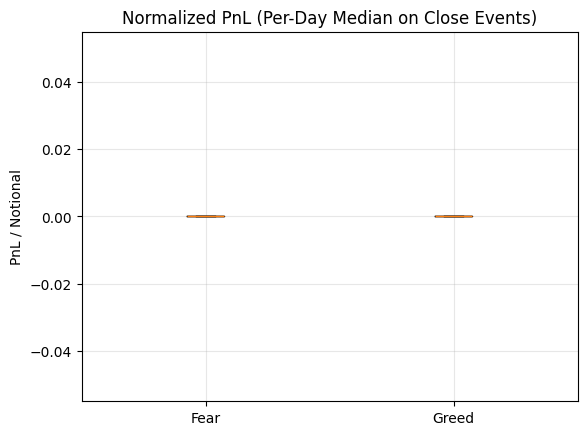

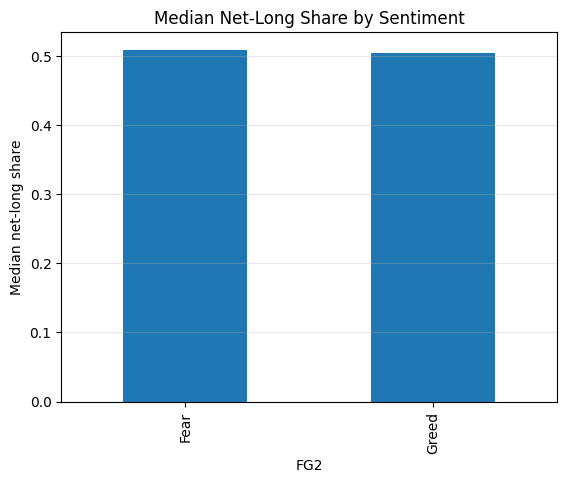

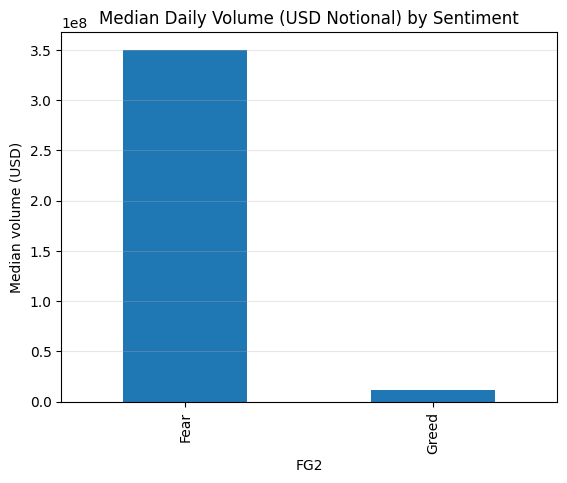

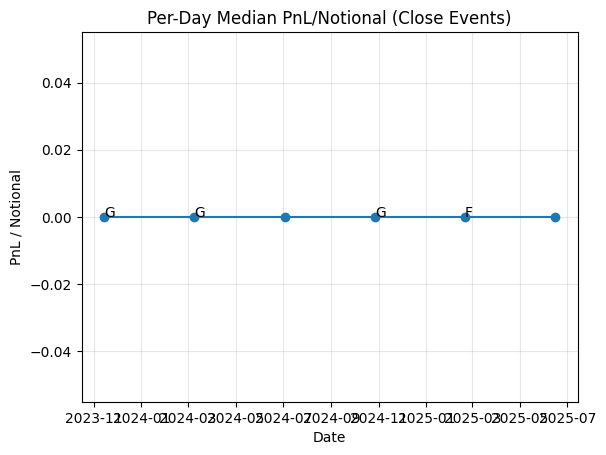

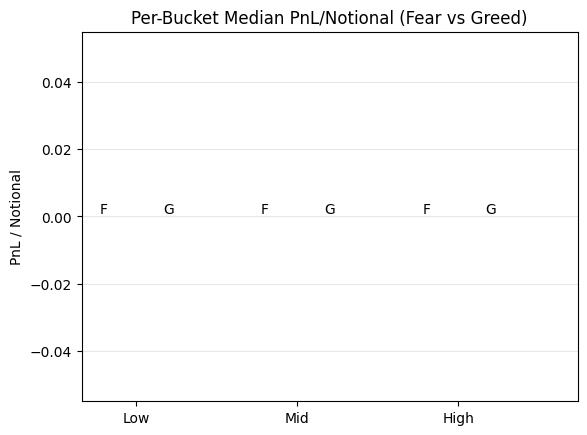

Saved figures to outputs/.


In [ ]:
import matplotlib.pyplot as plt, os
os.makedirs("outputs", exist_ok=True)

# Helper: boxplot by class
def save_boxplot(series_by_label, title, ylabel, fname):
    plt.figure()
    labels = list(series_by_label.keys())
    data = [np.asarray(series_by_label[k], dtype=float) for k in labels]
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title); plt.ylabel(ylabel); plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join("outputs", fname)); plt.show()

# 1) PnL/Notional per day (close events median), by FG2
d_bin = daily_full[daily_full["FG2"].isin(["Fear","Greed"])].copy()
fear_p = d_bin.loc[d_bin["FG2"]=="Fear",  "pnl_med"].dropna().values
greed_p= d_bin.loc[d_bin["FG2"]=="Greed", "pnl_med"].dropna().values
save_boxplot({"Fear": fear_p, "Greed": greed_p},
             "Normalized PnL (Per-Day Median on Close Events)", "PnL / Notional",
             "fig_pnl_norm_by_class.png")

# 2) Net-long share per class (bar)
plt.figure()
vals = d_bin.groupby("FG2")["net_long_share"].median()
vals.plot(kind="bar")
plt.title("Median Net-Long Share by Sentiment")
plt.ylabel("Median net-long share"); plt.grid(True, axis="y", alpha=0.3)
plt.savefig("outputs/fig_net_long_share_by_class.png"); plt.show()

# 3) Median daily volume by class (bar)
plt.figure()
d_bin.groupby("FG2")["volume_notional"].median().plot(kind="bar")
plt.title("Median Daily Volume (USD Notional) by Sentiment")
plt.ylabel("Median volume (USD)"); plt.grid(True, axis="y", alpha=0.3)
plt.savefig("outputs/fig_volume_by_class.png"); plt.show()

# 4) Time series: per-day PnL medians with FG2 markers
plt.figure()
ts = daily_full.sort_values("sentiment_day")
plt.plot(ts["sentiment_day"], ts["pnl_med"], marker="o")
for i,row in ts.iterrows():
    label = row.get("FG2")
    if label in ("Fear","Greed"):
        plt.text(row["sentiment_day"], row["pnl_med"], "F" if label=="Fear" else "G")
plt.title("Per-Day Median PnL/Notional (Close Events)"); plt.ylabel("PnL / Notional")
plt.xlabel("Date"); plt.grid(True, alpha=0.3)
plt.savefig("outputs/fig_ts_pnl_med.png"); plt.show()

# 5) Volatility buckets: class medians inside Low/Mid/High
plt.figure()
for idx, bucket in enumerate(["Low","Mid","High"], start=1):
    sub = daily_full[(daily_full["vol_bucket"]==bucket) & (daily_full["FG2"].isin(["Fear","Greed"]))]
    if sub.empty: continue
    med = sub.groupby("FG2")["pnl_med"].median()
    plt.bar([idx-0.2, idx+0.2], [med.get("Fear", np.nan), med.get("Greed", np.nan)])
    plt.text(idx-0.2, med.get("Fear", 0), "F", ha="center", va="bottom")
    plt.text(idx+0.2, med.get("Greed",0), "G", ha="center", va="bottom")
plt.xticks([1,2,3], ["Low","Mid","High"])
plt.title("Per-Bucket Median PnL/Notional (Fear vs Greed)")
plt.ylabel("PnL / Notional"); plt.grid(True, axis="y", alpha=0.3)
plt.savefig("outputs/fig_bucket_pnl_med.png"); plt.show()

print("Saved figures to outputs/.")


In [ ]:
%pip -q install scipy
from scipy import stats
import numpy as np

fear_vals  = d_bin["pnl_med"][d_bin["FG2"]=="Fear"].dropna().values
greed_vals = d_bin["pnl_med"][d_bin["FG2"]=="Greed"].dropna().values

print(f"Per-day PnL medians: Fear n={len(fear_vals)}, Greed n={len(greed_vals)}")
if len(fear_vals) and len(greed_vals):
    u = stats.mannwhitneyu(greed_vals, fear_vals, alternative="two-sided")
    print("Mann–Whitney U:", u)

def cliffs_delta(x, y):
    gt = 0; lt = 0
    for a in x:
        gt += np.sum(a > y)
        lt += np.sum(a < y)
    n = len(x)*len(y)
    return (gt - lt)/n if n else np.nan

if len(fear_vals) and len(greed_vals):
    print("Cliff’s δ (Greed vs Fear):", round(cliffs_delta(greed_vals, fear_vals), 4))

def bootstrap_ci_diff(x, y, n=20000, seed=0):
    if len(x)==0 or len(y)==0: return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.median(yb) - np.median(xb))
    return np.percentile(diffs, [2.5, 97.5])

ci = bootstrap_ci_diff(fear_vals, greed_vals)
print("Bootstrap 95% CI for Δ median PnL/Notional (Greed − Fear):", tuple(ci))


Per-day PnL medians: Fear n=1, Greed n=3
Mann–Whitney U: MannwhitneyuResult(statistic=np.float64(1.5), pvalue=np.float64(1.0))
Cliff’s δ (Greed vs Fear): 0.0
Bootstrap 95% CI for Δ median PnL/Notional (Greed − Fear): (np.float64(0.0), np.float64(0.0))


In [ ]:
def fmt(x):
    return "—" if pd.isna(x) else f"{x:.6g}"

summary = (d_bin.groupby("FG2")
              .agg(med_pnl_norm=("pnl_med","median"),
                   med_net_long=("net_long_share","median"),
                   med_volume_usd=("volume_notional","median"))
              .round(6))

fear_row  = summary.loc["Fear"]  if "Fear"  in summary.index else pd.Series(dtype=float)
greed_row = summary.loc["Greed"] if "Greed" in summary.index else pd.Series(dtype=float)

lines = [
    f"Days covered with labels: {int(d_bin['FG2'].notna().sum())} of {len(daily_full)}",
    f"Time window trades: {tr['sentiment_day'].min().date()} → {tr['sentiment_day'].max().date()}",
    "",
    "Headline deltas (Greed − Fear):",
    f"• Δ median PnL/Notional: {fmt(greed_row.get('med_pnl_norm', np.nan) - fear_row.get('med_pnl_norm', np.nan))}",
    f"• Δ median Net-Long Share: {fmt(greed_row.get('med_net_long', np.nan) - fear_row.get('med_net_long', np.nan))}",
    f"• Δ median Volume (USD): {fmt(greed_row.get('med_volume_usd', np.nan) - fear_row.get('med_volume_usd', np.nan))}",
]

exec_summary_text = "\n".join(lines)
print(exec_summary_text)


Days covered with labels: 4 of 6
Time window trades: 2023-11-14 → 2025-06-15

Headline deltas (Greed − Fear):
• Δ median PnL/Notional: 0
• Δ median Net-Long Share: -0.004502
• Δ median Volume (USD): -3.38744e+08


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt, textwrap, os, pandas as pd

os.makedirs("outputs", exist_ok=True)

def text_page(title, body_lines):
    fig = plt.figure(figsize=(8.27, 11.69))  # A4 portrait in inches
    txt = title + "\n\n" + "\n".join(body_lines)
    wrapped = "\n".join(textwrap.fill(l, width=95) for l in txt.split("\n"))
    plt.text(0.05, 0.95, wrapped, va="top", ha="left", family="monospace")
    plt.axis("off")
    return fig

# Compose report
with PdfPages("ds_report.pdf") as pdf:
    # 1) Title / Executive Summary
    body = [
        "Objective: Relate Hyperliquid trader outcomes and positioning to market sentiment (Fear vs Greed), BTC baseline.",
        "",
        *exec_summary_text.split("\n"),
        "",
        "Caveats:",
        "- Very small number of labeled days in this slice; treat p-values/effect sizes with caution.",
        "- Closed PnL used as a proxy for close events; no explicit event field in the dataset.",
        "- BTC-only baseline; alts may behave differently.",
    ]
    pdf.savefig(text_page("Fear–Greed × Hyperliquid — Executive Summary", body)); plt.close()


    fig_files = [
        "outputs/fig_pnl_norm_by_class.png",
        "outputs/fig_net_long_share_by_class.png",
        "outputs/fig_volume_by_class.png",
        "outputs/fig_ts_pnl_med.png",
        "outputs/fig_bucket_pnl_med.png",
    ]
    for f in fig_files:
        if os.path.exists(f):
            img = plt.imread(f)
            plt.figure(figsize=(11.69, 8.27))  # A4 landscape
            plt.imshow(img); plt.axis("off"); pdf.savefig(); plt.close()

    # 7) Methods & Robustness page
    body2 = [
        "Method (high-level):",
        "- Normalize trades to UTC; floor to day; map to daily sentiment labels.",
        "- Construct notional (Size USD or Size Tokens × Execution Price).",
        "- Analyze per-day medians of PnL/Notional on close events only; net-long share from notional.",
        "- Build a simple realized-volatility proxy (log-return std) and bucket into Low/Mid/High.",
        "",
        "Robustness checks:",
        "- Time alignment sensitivity (±1 day joins) — see CSVs in /csv_files.",
        "- Volatility-bucket comparisons for conditional effects.",
        "- Non-parametric tests (Mann–Whitney) + Cliff’s δ + bootstrap CI for medians.",
    ]
    pdf.savefig(text_page("Methods & Robustness", body2)); plt.close()

print("Saved ds_report.pdf")


Saved ds_report.pdf


In [ ]:
import os, json, datetime, pandas as pd

readme = f"""# Fear–Greed × Hyperliquid (BTC)

**Goal:** Explore how Hyperliquid trader outcomes and positioning relate to Bitcoin market sentiment (Fear vs Greed).

## Contents
- `notebooks/` (optional) — your exploratory notebook(s)
- `csv_files/`
  - `daily_metrics_base.csv` — per-day metrics + labels + vol buckets
  - `volatility_by_day.csv`
  - `daily_metrics_shift_-1d.csv`, `daily_metrics_shift_+1d.csv`
- `outputs/`
  - figures used in the report (`fig_*.png`)
- `ds_report.pdf` — 2–4 pages, executive-friendly summary

## Methods
- UTC normalization, per-day joining to sentiment (FG2 mapping).
- Notional = Size USD (preferred) or Size Tokens × Execution Price.
- PnL analysis on rows with non-null Closed PnL (proxy for close events).
- Volatility proxy = daily log-return std (intraday) → Low/Mid/High buckets.
- Non-parametric tests and effect sizes on per-day medians.

## Assumptions & Caveats
- Small number of labeled days in this slice; treat inferences cautiously.
- BTC-only baseline; alts may behave differently.
- Closed PnL used as close-event proxy.

*Generated on {datetime.date.today().isoformat()}.*
"""
with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme)

print("Submission checklist")
need = [
    "csv_files/daily_metrics_base.csv",
    "csv_files/volatility_by_day.csv",
    "csv_files/daily_metrics_shift_-1d.csv",
    "csv_files/daily_metrics_shift_+1d.csv",
    "outputs/fig_pnl_norm_by_class.png",
    "outputs/fig_net_long_share_by_class.png",
    "outputs/fig_volume_by_class.png",
    "outputs/fig_ts_pnl_med.png",
    "outputs/fig_bucket_pnl_med.png",
    "ds_report.pdf",
    "README.md",
]
for p in need:
    print(f"{'[OK]' if os.path.exists(p) else '[MISSING]'} {p}")


Submission checklist
[OK] csv_files/daily_metrics_base.csv
[OK] csv_files/volatility_by_day.csv
[OK] csv_files/daily_metrics_shift_-1d.csv
[OK] csv_files/daily_metrics_shift_+1d.csv
[OK] outputs/fig_pnl_norm_by_class.png
[OK] outputs/fig_net_long_share_by_class.png
[OK] outputs/fig_volume_by_class.png
[OK] outputs/fig_ts_pnl_med.png
[OK] outputs/fig_bucket_pnl_med.png
[OK] ds_report.pdf
[OK] README.md


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DEST = "/content/drive/MyDrive/Primetrade_AI"
import os
os.makedirs(DEST, exist_ok=True)
print("Destination:", DEST)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Destination: /content/drive/MyDrive/Primetrade_AI


In [ ]:
# Copy folders
!cp -rf /content/csv_files "$DEST"/
!cp -rf /content/outputs   "$DEST"/

# Copy files (force overwrite if they already exist)
!cp -f /content/ds_report.pdf "$DEST"/
!cp -f /content/README.md     "$DEST"/ 2>/dev/null || true
!cp -f /content/fear_greed_index*.csv "$DEST"/
!cp -f /content/historical_data*.csv  "$DEST"/

print("Copied.")


Copied.


In [ ]:
!echo "== Files in $DEST =="
!ls -lah "$DEST"
!echo "== Subfolders =="
!ls -lah "$DEST/csv_files" || true
!ls -lah "$DEST/outputs"   || true


== Files in /content/drive/MyDrive/Primetrade_AI ==
total 92M
drwx------ 2 root root 4.0K Sep 13 20:14  csv_files
-rw------- 1 root root 228K Sep 13 20:14  ds_report.pdf
-rw------- 1 root root  89K Sep 13 20:14 'fear_greed_index (1).csv'
-rw------- 1 root root  89K Sep 13 20:14  fear_greed_index.csv
-rw------- 1 root root  46M Sep 13 20:14 'historical_data (1).csv'
-rw------- 1 root root  46M Sep 13 20:14  historical_data.csv
drwx------ 2 root root 4.0K Sep 13 20:14  outputs
-rw------- 1 root root 1.1K Sep 13 20:14  README.md
== Subfolders ==
total 17M
-rw------- 1 root root 8.2M Sep 13 20:14 close_events_used.csv
-rw------- 1 root root 1.3K Sep 13 20:14 daily_metrics_base.csv
-rw------- 1 root root  747 Sep 13 20:14 daily_metrics_shift_+1d.csv
-rw------- 1 root root  745 Sep 13 20:14 daily_metrics_shift_-1d.csv
-rw------- 1 root root 8.2M Sep 13 20:14 trades_btc_sampled.csv
-rw------- 1 root root  346 Sep 13 20:14 volatility_by_day.csv
total 94K
-rw------- 1 root root 18K Sep 13 20:14